<a href="https://colab.research.google.com/github/maduraiarm/500-AI-Agents-Projects/blob/main/strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Optimization of Ichimoku Cloud Trading Strategy

In this notebook, we take the Ichimoku Cloud—a powerful technical indicator—and enhance a basic trading strategy using Bayesian Optimization. We will optimize the key Ichimoku parameters to maximize returns on historical AAPL stock data from 2020 to 2024, while visualizing the price, cloud, and buy/sell signals. This guide is beginner-friendly and shows how optimization can improve a classic trading approach.

## Install and Import Libraries

In [1]:
# Install necessary packages
%pip install yfinance matplotlib tabulate scikit-optimize -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.9 MB/s eta 0:00:00


## Import Libraries

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from skopt import gp_minimize
from skopt.space import Integer
import numpy as np

## Download Historical Data

In [15]:
# Download historical stock data
symbol = "BDL.NS"
data = yf.download(symbol, start="2018-01-01", end="2025-11-30")

# Flatten multi-level columns
data.columns = data.columns.get_level_values(0)
data.head()

/tmp/ipython-input-2414381953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start="2018-01-01", end="2025-11-30")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2018-03-23,170.456757,176.097845,158.300020,161.798363,7879318
2018-03-26,173.583435,181.301653,170.106951,170.456780,2348330
2018-03-27,177.344131,178.765333,174.698515,175.026484,1031072
2018-03-28,173.452225,177.103623,172.424584,175.354452,353908
2018-04-02,171.528137,175.791743,170.566088,174.479864,214862


## Plot the Closing Price

FileNotFoundError: [Errno 2] No such file or directory: 'figures/BDL.NS_closing_price.png'

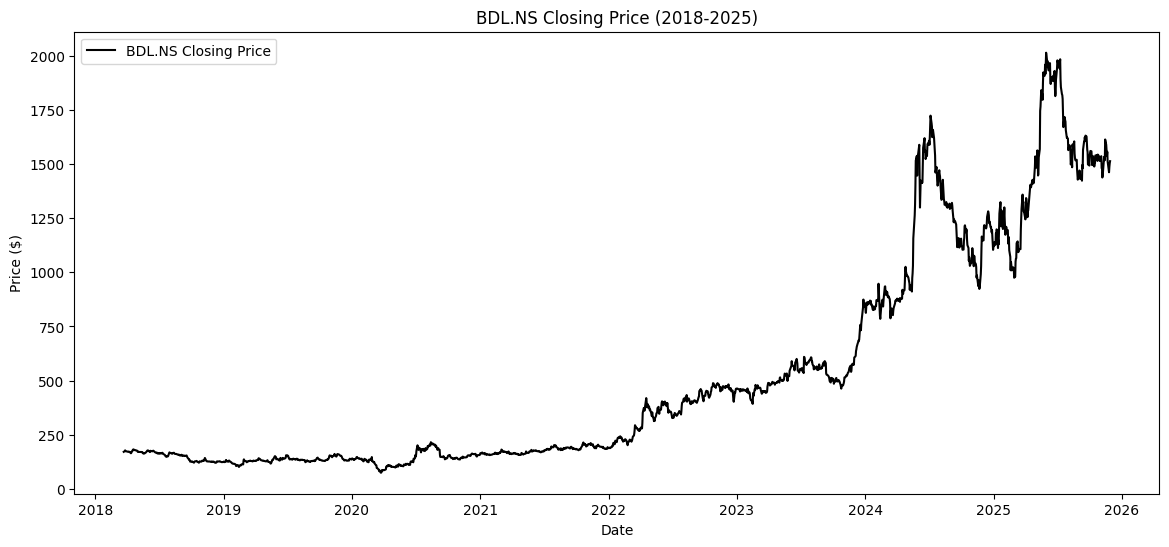

In [16]:
# Plot raw closing price
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Close'], color='black', linewidth=1.5, label=f"{symbol} Closing Price")
plt.title(f"{symbol} Closing Price (2018-2025)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.savefig(f"figures/{symbol}_closing_price.png", dpi=300)
plt.show()

## Define a Function to Calculate Ichimoku with Custom Parameters

In [24]:
def ichimoku_signals(data, tenkan_period, kijun_period, senkou_b_period):
    df = data.copy()
    high = df['High']
    low = df['Low']
    close = df['Close']

    # Ichimoku lines
    df['tenkan'] = (high.rolling(tenkan_period).max() + low.rolling(tenkan_period).min()) / 2
    df['kijun'] = (high.rolling(kijun_period).max() + low.rolling(kijun_period).min()) / 2
    df['senkou_a'] = ((df['tenkan'] + df['kijun']) / 2).shift(kijun_period)
    df['senkou_b'] = ((high.rolling(senkou_b_period).max() + low.rolling(senkou_b_period).min()) / 2).shift(kijun_period)

    # Signals
    df['above_cloud'] = df['Close'] > df[['senkou_a', 'senkou_b']].max(axis=1)
    df['tenkan_cross'] = (df['tenkan'] > df['kijun']) & (df['tenkan'].shift(1) <= df['kijun'].shift(1))
    df['signal'] = np.where(df['above_cloud'] & df['tenkan_cross'], 1, 0)

    # Backtest
    balance = 10000
    position = 0
    equity_curve = []

    for i in range(len(df)):
        if df['signal'].iloc[i] == 1 and position == 0:
            position = balance / df['Close'].iloc[i]
            balance = 0
        elif position > 0 and df['Close'].iloc[i] < df[['senkou_a','senkou_b']].min(axis=1).iloc[i]:
            balance = position * df['Close'].iloc[i]
            position = 0
        equity_curve.append(balance + position * df['Close'].iloc[i])

    df['equity'] = equity_curve
    total_return = (df['equity'].iloc[-1] - 10000) / 10000 * 100

    return df, total_return  # return the full df for plotting

## Define Objective Function for Bayesian Optimization

In [25]:
# Negative return because gp_minimize minimizes the function
def objective(params):
    tenkan, kijun, senkou_b = params
    _, total_return = ichimoku_signals(data, tenkan, kijun, senkou_b)  # discard df, keep return
    return -total_return  # gp_minimize minimizes

## Run Bayesian Optimization

In [29]:
search_space = [
    Integer(1, 20, name='tenkan_period'),    # Tenkan period
    Integer(20, 50, name='kijun_period'),    # Kijun period
    Integer(50, 100, name='senkou_b_period') # Senkou B period
]

result = gp_minimize(objective, search_space, n_calls=25, random_state=42)

## Display Optimized Parameters

In [30]:
best_tenkan, best_kijun, best_senkou_b = result.x
best_return = -result.fun

# Run strategy with optimized parameters to get equity curve
data_optimized, final_return = ichimoku_signals(data.copy(), best_tenkan, best_kijun, best_senkou_b)

# Calculate max drawdown
max_equity = data_optimized['equity'].cummax()
drawdown = (data_optimized['equity'] - max_equity) / max_equity
max_drawdown = drawdown.min() * 100  # convert to percentage

# Prepare stats table including max drawdown
stats = [
    ["Optimized Tenkan Period", best_tenkan],
    ["Optimized Kijun Period", best_kijun],
    ["Optimized Senkou B Period", best_senkou_b],
    ["Expected Total Return", f"{best_return:.0f}%"],
    ["Max Drawdown", f"{max_drawdown:.0f}%"]
]

print(tabulate(stats, headers=["Metric", "Value"], tablefmt="rounded_outline"))


╭───────────────────────────┬─────────╮
│ Metric                    │ Value   │
├───────────────────────────┼─────────┤
│ Optimized Tenkan Period   │ 18      │
│ Optimized Kijun Period    │ 20      │
│ Optimized Senkou B Period │ 77      │
│ Expected Total Return     │ 323%    │
│ Max Drawdown              │ -36%    │
╰───────────────────────────┴─────────╯


## Price + Ichimoku Cloud

FileNotFoundError: [Errno 2] No such file or directory: 'figures/BDL.NS_ichimoku_optimized_signals.png'

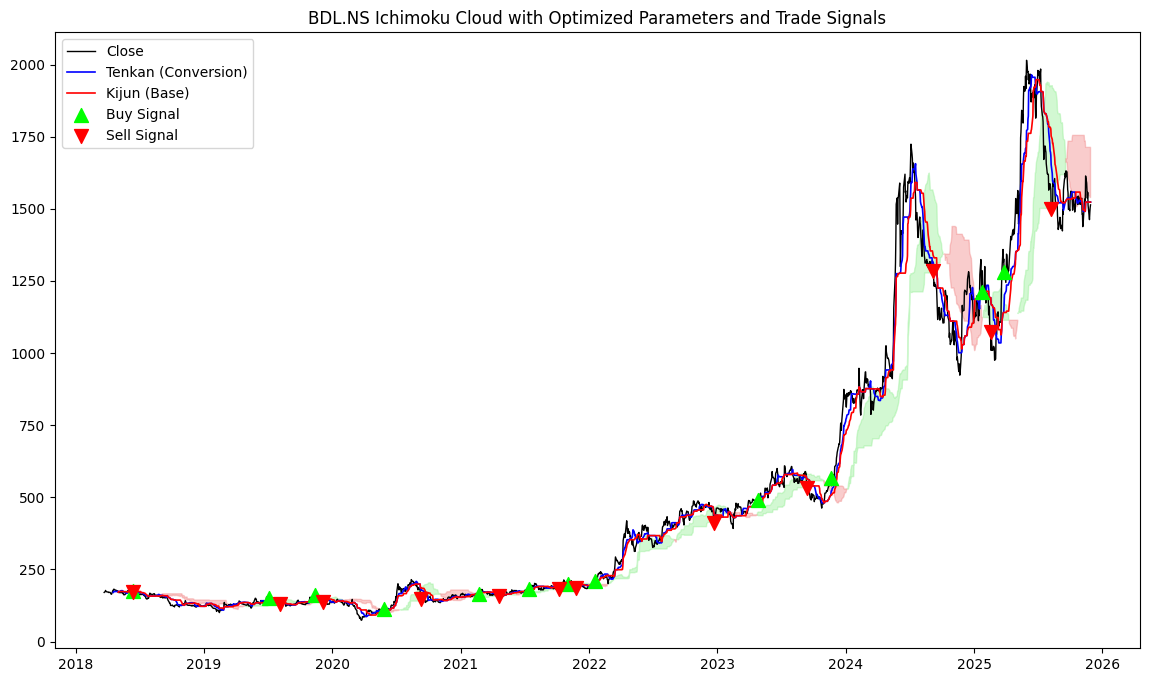

In [22]:
# Identify trades for optimized parameters
buy_points = []
sell_points = []
position = 0  # 0 = flat, 1 = long

for i in range(len(data_optimized)):
    if data_optimized['signal'].iloc[i] == 1 and position == 0:
        buy_points.append((data_optimized.index[i], data_optimized['Close'].iloc[i]))
        position = 1
    elif position == 1 and data_optimized['Close'].iloc[i] < data_optimized[['senkou_a','senkou_b']].min(axis=1).iloc[i]:
        sell_points.append((data_optimized.index[i], data_optimized['Close'].iloc[i]))
        position = 0

# Convert to DataFrames for plotting
buy_df = pd.DataFrame(buy_points, columns=["Date","Price"]).set_index("Date")
sell_df = pd.DataFrame(sell_points, columns=["Date","Price"]).set_index("Date")

# Plot price, Ichimoku lines, cloud, and trade signals
plt.figure(figsize=(14,8))
plt.plot(data_optimized.index, data_optimized['Close'], label="Close", color='black', linewidth=1)
plt.plot(data_optimized.index, data_optimized['tenkan'], label="Tenkan (Conversion)", color='blue', linewidth=1.2)
plt.plot(data_optimized.index, data_optimized['kijun'], label="Kijun (Base)", color='red', linewidth=1.2)

# Cloud area
plt.fill_between(
    data_optimized.index, data_optimized['senkou_a'], data_optimized['senkou_b'],
    where=data_optimized['senkou_a'] >= data_optimized['senkou_b'],
    color='lightgreen', alpha=0.4
)
plt.fill_between(
    data_optimized.index, data_optimized['senkou_a'], data_optimized['senkou_b'],
    where=data_optimized['senkou_a'] < data_optimized['senkou_b'],
    color='lightcoral', alpha=0.4
)

# Buy & Sell signals with higher zorder and lime color
plt.scatter(buy_df.index, buy_df['Price'], marker="^", color="lime", s=100, label="Buy Signal", zorder=5)
plt.scatter(sell_df.index, sell_df['Price'], marker="v", color="red", s=100, label="Sell Signal", zorder=5)

plt.title(f"{symbol} Ichimoku Cloud with Optimized Parameters and Trade Signals")
plt.legend(loc="upper left")
plt.savefig(f"figures/{symbol}_ichimoku_optimized_signals.png", dpi=300)
plt.show()